conda install -c conda-forge lightfm
conda  install libomp-dev
conda install -c conda-forge/label/gcc7 lightfm

conda install -c conda-forge/label/cf201901 lightfm

conda install -c conda-forge/label/cf201901 lightfm

In [1]:
!pip uninstall pil

conda install -n myenv 
 conda create --name myenvv python=3.9.16
 
 conda install -c conda-forge lightfm
conda activate myenvv

 conda create --name newenv python=3.9.16
 conda info --envs     какая среда conda в данный момент .
python -V    
conda list
 conda  
!pip install   pandas    


   conda env remove -n myenvv    чтобы удалить среду 
conda install -n myenvv  matplotlib
conda envs remove -n myenv

In [1]:
import pandas as pd
import numpy as np

import datetime 
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from   xgboost  import XGBClassifier
from sklearn import metrics

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from sklearn import preprocessing

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
import pickle

In [10]:
import pickle

In [2]:
with open('E:\\DIPLOMA\\data.pickle','rb') as f:
    data = pickle.load(f)
data   

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night,NaN,NaN,NaN,NaN
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night,NaN,NaN,NaN,NaN
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,12,2015,0,Night,NaN,NaN,NaN,NaN
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755636,591435,view,261427,NaN,2015-08-01 03:13:05.939,3,8,5,1,13,2015,0,Night,NaN,NaN,NaN,NaN
2755637,762376,view,115946,NaN,2015-08-01 03:30:13.142,3,8,5,1,30,2015,0,Night,NaN,NaN,NaN,NaN
2755638,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2,8,5,1,57,2015,0,Night,NaN,NaN,NaN,NaN
2755639,1184451,view,283392,NaN,2015-08-01 03:08:50.703,3,8,5,1,8,2015,0,Night,NaN,NaN,NaN,NaN


In [3]:
need_cols =  ['data', 'itemid', 'visitorid', 'event']
df = data[need_cols]

Валидационный датасет
Создадим валидационный датасет, разбив данные по времени. Для этого возьмем последние семь дней данных в качестве валидационного периода.

In [5]:
train = data[pd.to_datetime(df['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
test = data[pd.to_datetime(df['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [6]:
print(f'train : {train.shape}')
print(f'test: {test.shape}')

train : (2150769, 17)
test: (604872, 17)


# XGBoost


## Для решения задачи классификации добавим в наши данные таргет - 1 при наличии тразакции и 0, если транзакции не было.

In [8]:
train['target'] = train['event'].apply(lambda x: 1 if  x=='transaction' else 0)
test['target'] = test['event'].apply(lambda x: 1 if  x=='transaction' else 0)

In [9]:
cat_features = ['visitorid', 'itemid', 'day_of_week',
       'Month', 'Day', 'Hour', 'minute', 'target']

In [10]:
cat_features

['visitorid',
 'itemid',
 'day_of_week',
 'Month',
 'Day',
 'Hour',
 'minute',
 'target']

In [10]:
# Случайная неполная выборка (нахождение класса большинства и его неполная выборка)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1


def create_dataframe(visitor): 

    visitor_df_array = []

    for x in visitor:

        #Создание массива, содержащего все данные о посетителе, кроме id
        v_df = data[data.visitorid == x]
        #Создание временного массива для хранения всех атрибутов посетителей
        temp = []
        #Заполнение первого элемента массива текущим индексом
        temp.append(x)
        #Заполнение массива количеством уникальных товаров, просмотренных посетителем (num_uniq_items_viewed)
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)
        # Заполнение массива количеством просмотров товаров посетителем независимо от того, тот же это продукт или нет (num_views_total)
        temp.append(v_df[v_df.event == 'view'].event.count())
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)
       
        # если посетитель купил хотя бы 1 товар, атрибуту присваивается значение 1, если посетитель ничего не купил, присваивается значение 0
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        visitor_df_array.append(temp)

    return pd.DataFrame(visitor_df_array, columns=['visitorid', 'num_uniq_items_viewed', 'num_views_total', 'bought_count', 'purchased'])

In [11]:
train = random_under(train, 'target')

Class 0: 17455
Class 1: 17455
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

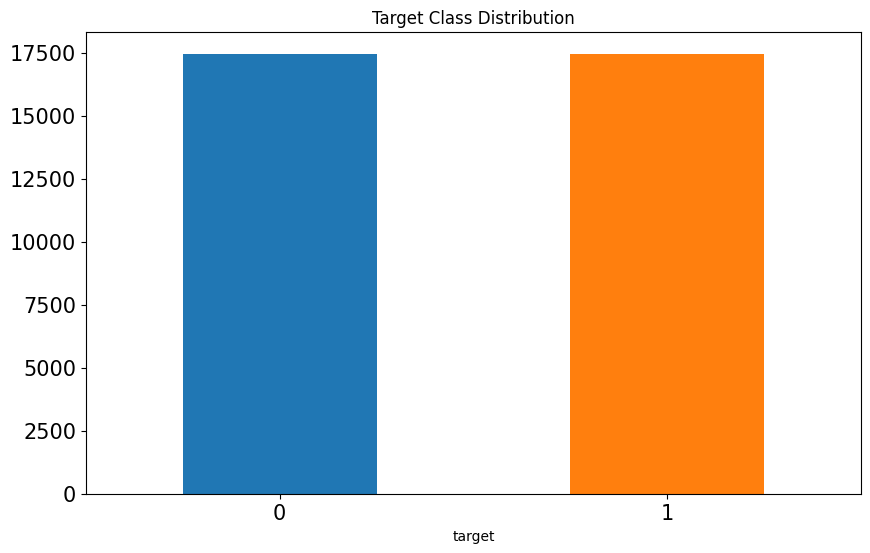

In [12]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['target'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

In [13]:
X_train = train[['visitorid', 'itemid', 'day_of_week','month', 'hour']]
X_test = test[['visitorid', 'itemid', 'day_of_week','month', 'hour']]
y_train = train['target']
y_test = test['target']

In [14]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
preds = xgb.predict(X_test)

In [16]:
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, preds)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, preds)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, preds)))

precision_score =  0.0114
recall_score =  0.4230
f1_score =  0.0223
accuracy =  0.6926


In [17]:
from catboost import CatBoostClassifier

In [18]:
cb = CatBoostClassifier(n_estimators=1000)

# Обучение модели
cb.fit(X_train, y_train)

Learning rate set to 0.046965
0:	learn: 0.6920366	total: 160ms	remaining: 2m 40s
1:	learn: 0.6911150	total: 168ms	remaining: 1m 23s
2:	learn: 0.6901747	total: 175ms	remaining: 58.1s
3:	learn: 0.6893732	total: 182ms	remaining: 45.4s
4:	learn: 0.6884865	total: 190ms	remaining: 37.8s
5:	learn: 0.6877121	total: 196ms	remaining: 32.5s
6:	learn: 0.6870345	total: 203ms	remaining: 28.8s
7:	learn: 0.6864621	total: 209ms	remaining: 25.9s
8:	learn: 0.6859168	total: 217ms	remaining: 23.8s
9:	learn: 0.6851791	total: 224ms	remaining: 22.2s
10:	learn: 0.6846774	total: 231ms	remaining: 20.8s
11:	learn: 0.6841672	total: 239ms	remaining: 19.7s
12:	learn: 0.6836995	total: 245ms	remaining: 18.6s
13:	learn: 0.6833303	total: 253ms	remaining: 17.8s
14:	learn: 0.6827136	total: 260ms	remaining: 17.1s
15:	learn: 0.6823490	total: 266ms	remaining: 16.3s
16:	learn: 0.6819508	total: 273ms	remaining: 15.8s
17:	learn: 0.6815744	total: 281ms	remaining: 15.3s
18:	learn: 0.6809952	total: 288ms	remaining: 14.8s
19:	learn

In [19]:
pred = cb.predict(X_test)

In [20]:
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, pred)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, pred)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, pred)))

precision_score =  0.0121
recall_score =  0.4156
f1_score =  0.0223
accuracy =  0.7150


# Коллаборативная фильтрация

###  список всех идентификаторов клиентов.

In [21]:
all_visitors = data.visitorid.sort_values().unique() 
all_visitors.size

1407580

###  список клиентов, которые что-то купили.

In [22]:
buy_visitors = data[data.event == 'transaction'].visitorid.sort_values().unique()
buy_visitors.size 

11719

In [23]:
view_visitors = list([x for x in all_visitors if x not in buy_visitors])

In [24]:
buy_visitors_df = create_dataframe(buy_visitors)

In [25]:
buy_visitors_df.head(3)

,visitorid,num_uniq_items_viewed,num_views_total,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1


In [26]:
trainCF = data[pd.to_datetime(data['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testCF = data[pd.to_datetime(data['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

### список, который содержит заказы клиентов и элементы внутри них.

In [27]:
purchased_items = []
    
for customer in buy_visitors:
    purchased_items.append(list(data.loc[(data.visitorid == customer) & (data.transactionid.notnull())].itemid.values))  

 ### функция, которая выдавала бы список товаров, которые были куплены вместе с указанным товаром.

In [28]:
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

###  функцию расчета метрики.

In [29]:
def metrik_p3(df): 
  res = len(set(top3) & set(df))
  p_3= round((res/3),2)  
  return p_3

 ###  введем идентификатор элемента, получим список элементов, которые появились в заказах с указанным элементом.

In [30]:
recommender_bought_bought(302422, purchased_items)[:3]

[105792, 200793, 12836]

 список ТОП-3 товаров.

In [31]:
top3 = list(train.itemid.value_counts()[:3].index)
top3

[461686, 119736, 213834]

 ## метрика на 30 произвольных записи из тестовой части.

In [32]:
test_sample = testCF[testCF['event']=='transaction'].sample(n=30)

In [33]:
test_sample.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid
1315332,121320,transaction,364437,53.0,2015-09-09 20:26:47.055,20,9,2,0,26,2015,0,Evening,NaN,NaN,NaN,NaN
1453598,346832,transaction,446934,16098.0,2015-09-16 19:45:23.298,19,9,2,0,45,2015,0,Evening,NaN,NaN,NaN,NaN
1309065,738908,transaction,219755,12875.0,2015-09-10 00:14:10.203,0,9,3,0,14,2015,0,Night,NaN,NaN,NaN,NaN


In [34]:
test_sample['1'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[0:1])
test_sample['2'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[1:2])
test_sample['3'] =test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[2:3])

In [35]:
def replace_col(df):
  df =  df.apply(lambda x: str(x).replace('[', ''))
  df =  df.apply(lambda x: str(x).replace(']', ''))
  return df

In [36]:
test_sample['1'] =  replace_col(test_sample['1'])
test_sample['2'] =  replace_col(test_sample['2'])
test_sample['3'] =  replace_col(test_sample['3'])
test_sample['1'] = test_sample['1'].apply(lambda x: top3[0] if x=='' else x)
test_sample['2'] = test_sample['2'].apply(lambda x: top3[1] if x=='' else x)
test_sample['3'] = test_sample['3'].apply(lambda x: top3[2] if x=='' else x)

In [37]:
test_sample['pred'] = test_sample[['1', '2', '3']].values.tolist()

In [38]:
test_sample['p@3'] = 0

In [39]:
index = test_sample.pred.index
for i in index:
  test_sample['p@3'][i] = metrik_p3(test_sample['pred'][i])

In [40]:
test_sample.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,...,time_of_day,property,value,categoryid,parentid,1,2,3,pred,p@3
1315332,121320,transaction,364437,53.0,2015-09-09 20:26:47.055,20,9,2,0,26,...,Evening,NaN,NaN,NaN,NaN,387756,119736,213834,"[387756, 119736, 213834]",0.67
1453598,346832,transaction,446934,16098.0,2015-09-16 19:45:23.298,19,9,2,0,45,...,Evening,NaN,NaN,NaN,NaN,348677,259078,26634,"[348677, 259078, 26634]",0.00
1309065,738908,transaction,219755,12875.0,2015-09-10 00:14:10.203,0,9,3,0,14,...,Night,NaN,NaN,NaN,NaN,444931,429765,254406,"[444931, 429765, 254406]",0.00


In [41]:
# Precision@3
metric = round(test_sample['p@3'].mean(),2)
print('Mean Average Precision at 3: {:.2}'.format(metric))

Mean Average Precision at 3: 0.31


# ALS

In [42]:
dfALS = data.copy()

In [43]:
dfALS['event_scores'] = dfALS['event'].apply(
    lambda x: 1 if x == 'view' else 5 if x == 'addtocart' else 25 if x == 'transaction' else 0
)

In [44]:
dfALS.head(3)

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid,event_scores
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN,1
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night,NaN,NaN,NaN,NaN,1
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night,NaN,NaN,NaN,NaN,1


 ###  преобразуем стобцы их в разреженную матрицу для экономии места и чтобы наша модель была способна вычислять все возможные взаимодействия в наборе данных. По  модулю scipy.sparse.

In [45]:
dfALS['visitorid'] = dfALS['visitorid'].astype("category").cat.as_ordered()
dfALS['itemid'] = dfALS['itemid'].astype("category").cat.as_ordered()

sparse_item_user = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['itemid'], dfALS['visitorid'])))
sparse_user_item = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['visitorid'], dfALS['itemid'])))

In [46]:
trainALS = dfALS[pd.to_datetime(dfALS['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testALS = dfALS[pd.to_datetime(dfALS['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [47]:
trainALS['visitorid'] = trainALS['visitorid'].astype("category").cat.as_ordered()
trainALS['itemid'] = trainALS['itemid'].astype("category").cat.as_ordered()

testALS['visitorid'] = testALS['visitorid'].astype("category").cat.as_ordered()
testALS['itemid'] = testALS['itemid'].astype("category").cat.as_ordered()

In [48]:
sparse_train_item_user = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['itemid'], trainALS['visitorid'])))
sparse_train_user_item = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['visitorid'], trainALS['itemid'])))

In [49]:
sparse_test_item_user = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['itemid'], testALS['visitorid'])))
sparse_test_user_item = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['visitorid'], testALS['itemid'])))

 ### матрицы готовы, мы можем параметризовать и подогнать нашу модель.

#### Используемые параметры являются довольно стандартными: латентные_факторы и n_iter параметры, которые изменяются чаще, поскольку их увеличение увеличило бы прогностическую силу нашей модели за счет более высоких вычислений, использования памяти и вероятности переобучения для нашей оценки.

In [50]:
latent_factors = 20
regularization = 0.1
n_iter = 20
alpha = 40

conf_matrix = (sparse_train_item_user * alpha).astype('double')

model = AlternatingLeastSquares(
    factors=latent_factors,
    regularization=regularization,
    iterations=n_iter
)

model.fit(conf_matrix)

100%|██████████| 20/20 [04:56<00:00, 14.82s/it]


In [52]:
p_at3_als = mean_average_precision_at_k(model, sparse_train_item_user, sparse_test_item_user, K=3)
print('Mean Average Precision at 3: {:.2%}'.format(p_at3_als))

  0%|          | 0/119873 [00:00<?, ?it/s]

  0%|          | 0/119873 [00:04<?, ?it/s]


MemoryError: Unable to allocate 537. MiB for an array with shape (100, 1407580) and data type float32

In [ ]:
def recommend_item_to_user(model, visitorid, sparse_test_item_user, n=3):
    recommended = model.recommend(visitorid, sparse_test_item_user[visitorid], n)
    return recommended


def similar_items_to_item(model, itemid, n=3):
    similar = model.similar_items(itemid, n)
    return similar

In [ ]:
userid = 1233
recommended_items = recommend_item_to_user(model, userid, sparse_test_item_user)
print(f"Recommended items for user {userid}:\n{recommended_items[0]}")

Recommended items for user 1233:
[1093035  138131  229157]


In [ ]:
itemid =456
similar_items = similar_items_to_item(model, itemid)
print(f"Similar items to {itemid}:\n{similar_items[0]}")

Similar items to 456:
[352640 263556    456]


In [7]:
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset

In [8]:
trainLFM = data[pd.to_datetime(data['data'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testLFM = data[pd.to_datetime(data['data'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]
     

all_visitorids = data.visitorid.unique()
all_itemids = data.itemid.unique()
     

dataset = Dataset()
     

dataset.fit(users=all_visitorids, items=all_itemids)
     

train_coo = dataset.build_interactions(trainLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)
     

test_coo = dataset.build_interactions(testLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [9]:
import lightfm

conda install -c conda-forge lightfm

In [10]:
from lightfm import LightFM

In [11]:
modelLFM = LightFM(loss='warp', no_components=50, random_state=42)
modelLFM.fit(train_coo[0], epochs=20)

: 

In [ ]:
p_at3 = precision_at_k(modelLFM, test_coo[0], k=3).mean()
print('Mean Average Precision at 3: {:.2%}'.format(p_at3))

In [ ]:
import numpy as np
scores = modelLFM.predict(1, np.arange(len(all_itemids)))
top = np.argsort(-scores)[:3]
item_lagels = {v:k for k, v in dataset.mapping()[2].items()}

In [ ]:
[item_lagels[k] for k in top]

In [ ]:
#количество пользователей и товаров в обучающих данных
df = data[['itemid']]
items = df.to_numpy()

def sample_recommendation(model, data, user_ids):

    n_users, n_items = data.shape

    #generate recommendations for each user we input
    for user_id in user_ids:

        #movies our model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))

        #rank them in order of most liked to least
        top_items = items[np.argsort(-scores)][:3]

        print(top_items)

In [ ]:
sample_recommendation(modelLFM, test_coo[0], [1])

# Сохранение

In [ ]:
with open('E:\\DIPLOMA\\lightfm_model.pickle', 'wb') as f: 
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
visitors_items_mapping = dataset.mapping()

In [ ]:
dataset.mapping()

In [ ]:
with open('E:\\DIPLOMA\\lightfm_data_mapping.pickle', 'wb') as f:
    pickle.dump(visitors_items_mapping , f, protocol=pickle.HIGHEST_PROTOCOL)

# чтение

In [4]:
with open('E:\\DIPLOMA\\lightfm_data_mapping.pickle', 'rb') as f:
    loaded_model1 = pickle.load(f)

In [5]:
loaded_model1

({257597: 0,
  992329: 1,
  111016: 2,
  483717: 3,
  951259: 4,
  972639: 5,
  810725: 6,
  794181: 7,
  824915: 8,
  339335: 9,
  176446: 10,
  929206: 11,
  15795: 12,
  598426: 13,
  223343: 14,
  57036: 15,
  1377281: 16,
  287857: 17,
  1370216: 18,
  158090: 19,
  1398644: 20,
  653756: 21,
  1213673: 22,
  864246: 23,
  125625: 24,
  608100: 25,
  781127: 26,
  1076270: 27,
  453474: 28,
  1153198: 29,
  273888: 30,
  849453: 31,
  487887: 32,
  629333: 33,
  1130165: 34,
  361387: 35,
  112175: 36,
  860082: 37,
  784669: 38,
  1061147: 39,
  485456: 40,
  1342963: 41,
  969887: 42,
  759369: 43,
  1282360: 44,
  233317: 45,
  392042: 46,
  591038: 47,
  692195: 48,
  432882: 49,
  808133: 50,
  180680: 51,
  1151716: 52,
  597724: 53,
  179437: 54,
  794013: 55,
  975530: 56,
  741702: 57,
  1219180: 58,
  1143908: 59,
  1078178: 60,
  503970: 61,
  1193904: 62,
  376913: 63,
  1262470: 64,
  238317: 65,
  800456: 66,
  1219627: 67,
  526166: 68,
  685949: 69,
  721839: 70,
 

In [6]:
with open('E:\\DIPLOMA\\lightfm_model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

In [7]:
loaded_model

## Создание контейнера:
docker build -t diploma .


### .

## Запуск контейнера:

### docker run -d -p 8888:8888 diploma 


### docker run --name diplom -d -p 8888:8888 diploma

## Просмотр результата:  

http://127.0.0.1:8888/?visitorid=5

## Для остановки сервиса:

### docker ps -a

### docker stop <docker_id>

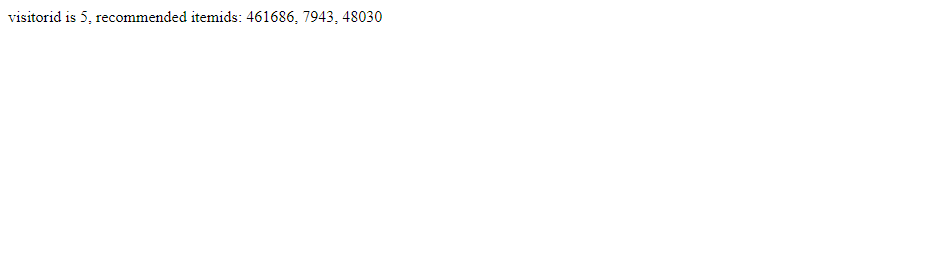

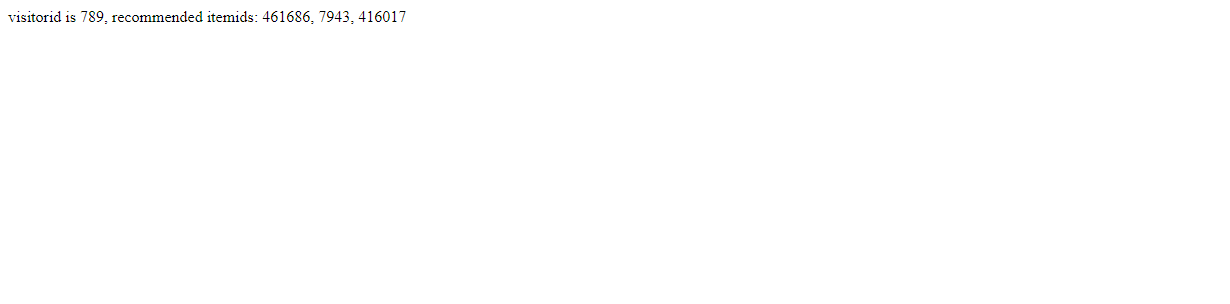